<a id="top"></a>

Should probably view this in [nbviewer](https://nbviewer.org/github/jackiec1998/resilient-communities/blob/main/src/notebooks/new_analysis.ipynb) for a better experience if you're on GitHub right now.

# Shortcuts
- [Thread Features](#thread) - [Thread Master](#thread_master)
- [Subreddit Features](#subreddit) - [Subreddit Master](#subreddit_master)
- [Other](#other)
- [Regression Analysis](#regression)

In [461]:
%config Completer.use_jedi = False
from IPython.core.debugger import set_trace
from pymongo import MongoClient
import pandas as pd
import numpy as np
import datetime as dt
from collections import defaultdict
from dotenv import load_dotenv
import time
import glob
import os
from tqdm import tqdm

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import praw

load_dotenv()

reddit = praw.Reddit(
    client_id=os.environ.get('REDDIT_CLIENT_ID_2'),
    client_secret=os.environ.get('REDDIT_CLIENT_SECRET_2'),
    user_agent=os.environ.get('REDDIT_USER_AGENT_2'),
    username=os.environ.get('REDDIT_USERNAME_2'),
    password=os.environ.get('REDDIT_PASSWORD_2')
)

os.chdir('/shared/jackie/resilient-communities/')

client = MongoClient('localhost', 27017)
all_comments = client.resilient.all
popular_snapshots = client.resilient.popular
ps_comments = client.pushshift_comments
ps_threads = client.pushshift_threads

---
# Utility Functions

In [652]:
# Returns subreddits with complete Pushshift data.
def get_available_subreddits():
    
    with open('logs/collect-pushshift.log') as file:
        current_subreddit = file.read().split('\n')[-2].split(' ')[4][2:]
    
    return [subreddit for subreddit in open('sample.txt', 'r').read().split()
            if subreddit in ps_comments.list_collection_names()
            and subreddit in ps_threads.list_collection_names()
            and subreddit != current_subreddit]

def display_dataframe(df, column_list, ignore_remainder=False):
    remaining_columns = set(df.columns)
    all_columns = [column for sub_list in column_list for column in sub_list]
    
    for column in all_columns:
        assert column in df.columns.to_list(), f'{column} is not in data frame columns.'
    
    for columns in column_list:
        display(df[columns])
        remaining_columns -= set(columns)
        
    if all_columns != {} and not ignore_remainder:
        display(df[list(remaining_columns)])
        
    display(df.dtypes.to_frame().rename(columns={0: 'Type'}))
    
def get_fullnames(thread_ids):
    return ['t3_' + thread for thread in thread_ids]

STUDY_SUBREDDITS = get_available_subreddits()

---
# Get Thread-Level Features
[Back to Top](#top)

[Go to Thread Master](#thread_master)

<a id="thread"></a>

## Get thread features from r/all collection.

In [648]:
def get_all_thread_features(subreddits=None):
    pipeline = [
        {'$project': {'_id': 1, 'link_id': 1, 'created_utc': 1, 'author': 1}},
        {'$group': {'_id': {'author': '$author', 'link_id': '$link_id'},
                    'first_utc': {'$min': '$created_utc'},
                    'last_utc': {'$max': '$created_utc'},
                    'num_comments': {'$sum': 1}}},
        {'$group': {'_id': '$_id.link_id',
                    'num_comments': {'$sum': '$num_comments'},
                    'first_utc': {'$min': '$first_utc'},
                    'last_utc': {'$max': '$last_utc'},
                    'num_authors': {'$sum': 1}}}
    ]

    if subreddits is not None:
        pipeline = [{'$match': {'subreddit': {'$in': subreddits}}}] + pipeline

    all_thread_features = pd.DataFrame(all_comments.aggregate(
        pipeline, allowDiskUse=True)).rename(columns={'_id': 'id'}).set_index('id')

    all_thread_features.index = all_thread_features.index.str[3:]

    all_thread_features['active_window'] = \
        all_thread_features['last_utc'] - all_thread_features['first_utc']

    return all_thread_features


all_thread_features = get_all_thread_features(STUDY_SUBREDDITS)
all_thread_features

,num_comments,first_utc,last_utc,num_authors,active_window
id,,,,,
tp35v6,12,1.648326e+09,1.648393e+09,12,66792.0
tou1js,4,1.648310e+09,1.648313e+09,4,2281.0
tnqk8g,1154,1.648227e+09,1.649603e+09,554,1375396.0
tagmcs,3,1.649971e+09,1.650499e+09,2,527748.0
tx3m5k,7,1.649189e+09,1.649278e+09,3,89356.0
...,...,...,...,...,...
tp7heo,53,1.648338e+09,1.648484e+09,42,146092.0
tyibyt,44,1.649354e+09,1.649413e+09,30,59572.0
tnin9y,1,1.648203e+09,1.648203e+09,1,0.0


## Get removed comment thread features.

In [649]:
def get_requery_features(subreddits):

    files = glob.glob('removed/*')
    available_subreddits = [file.split('/')[1][:-4] for file in files]

    assert all(subreddit in available_subreddits for subreddit in subreddits), \
        'Don\'t have removed data for a subreddit given.'

    requeried_comments = []

    for file in files:
        requeried_comments.append(pd.read_pickle(file))

    requeried_comments = pd.concat(requeried_comments, ignore_index=True) \
        .set_index('id')

    # Get the comments from r/all collection.
    comments = pd.DataFrame(
        all_comments.find(
            {'subreddit': {'$in': subreddits}},
            {'link_id': 1,
             'id': 1,
             '_id': 0}
        )
    ).set_index('id')

    comments['link_id'] = comments['link_id'].str[3:]

    # Connecting all comments with the comments you requeried. Dropping ones that weren't requeried.
    comments = comments.join(
        requeried_comments.rename(columns={
            'retrieved_utc': 'requeried_utc'
        })
    ).dropna(subset=['removed', 'requeried_utc'])

    comments['removed'] = comments['removed'].astype(int)
    
    comments['num_requery'] = np.ones(comments.shape[0]).astype(int)

    comments = comments.groupby('link_id') \
        .agg({'removed': 'sum',
              'num_requery': 'sum'}) \
        .rename(columns={'removed': 'num_removed'}) \
        .sort_values(by='num_removed', ascending=False)
    
    comments['percent_removed'] = comments['num_removed'] / comments['num_requery']
    
    return comments


requery_features = get_requery_features(STUDY_SUBREDDITS)
requery_features

,num_removed,num_requery,percent_removed
link_id,,,
tneqx6,729,4609,0.158169
u0sza8,714,5519,0.129371
u4q4uk,570,607,0.939044
u4xf5g,363,369,0.983740
tpm3r5,363,6192,0.058624
...,...,...,...
tsgcbf,0,11,0.000000
tsgayt,0,1,0.000000
tsg8cx,0,1,0.000000


## Get r/popular thread features.

In [650]:
def get_popular_thread_features(subreddits=None):

    pipeline = [
        {'$sort': {'retrieved_utc': 1}},  # So the snapshot push is in order.
        {'$group': {'_id': '$id',
                    'subreddit': {'$first': '$subreddit'},
                    'created_utc': {'$first': '$created_utc'},
                    'title': {'$first': '$title'},
                    'domain': {'$first': '$domain'},
                    'is_self': {'$first': '$is_self'},
                    'author': {'$first': '$author'},
                    'selftext': {'$first': '$selftext'},
                    'is_video': {'$first': '$is_video'},
                    'num_snapshots': {'$sum': 1},
                    'max_utc': {'$max': '$retrieved_utc'},
                    'min_utc': {'$min': '$retrieved_utc'},
                    'max_rank': {'$min': '$rank'},
                    'mean_rank': {'$avg': '$rank'},
                    'max_upvotes': {'$max': '$score'},
                    'mean_upvotes': {'$avg': '$score'},
                    'max_upvote_ratio': {'$max': '$upvote_ratio'},
                    'mean_upvote_ratio': {'$avg': '$upvote_ratio'},
                    'snapshots': {'$push': {
                        'retrieved_utc': '$retrieved_utc',
                        'rank': '$rank',
                        'score': '$score',
                        'upvote_ratio': '$upvote_ratio',
                        'num_comments': '$num_comments'}}}},
        {'$sort': {'num_snapshots': -1}}
    ]
    
    if subreddits is not None:
        pipeline = [{'$match': {'subreddit': {'$in': subreddits}}}] + pipeline

    popular_threads = pd.DataFrame(
        popular_snapshots.aggregate(pipeline, allowDiskUse=True)
    ).rename(columns={'_id': 'id'}).set_index('id')

    for column in ['created_utc', 'max_utc', 'min_utc']:
        new_column = column.split('_')[0] + '_datetime'

        popular_threads[new_column] = \
            pd.to_datetime(popular_threads[column], unit='s') \
            .dt.tz_localize('UTC') \
            .dt.tz_convert('US/Central')

    popular_threads['created_to_popular'] = popular_threads['min_utc'] - \
        popular_threads['created_utc']

    popular_threads['popular_window'] = popular_threads['max_utc'] - \
        popular_threads['min_utc']

    return popular_threads


popular_thread_features = get_popular_thread_features(STUDY_SUBREDDITS)
popular_thread_features

,subreddit,created_utc,title,domain,is_self,author,selftext,is_video,num_snapshots,max_utc,...,max_upvotes,mean_upvotes,max_upvote_ratio,mean_upvote_ratio,snapshots,created_datetime,max_datetime,min_datetime,created_to_popular,popular_window
id,,,,,,,,,,,,,,,,,,,,,
ty8o6y,CasualUK,1.649321e+09,Disappointingly accurate,i.redd.it,False,Thunder-biscuit,,False,555,1649401461,...,23994,16688.998198,0.96,0.933081,"[{'retrieved_utc': 1649333293, 'rank': 90, 'sc...",2022-04-07 03:47:13-05:00,2022-04-08 02:04:21-05:00,2022-04-07 07:08:13-05:00,12060.0,68168
tr83x7,HistoryPorn,1.648572e+09,"In 1973, Marlon Brando rejected his Oscar for ...",i.redd.it,False,WhenPigsRideCars,,False,527,1648649674,...,45955,30972.815939,0.96,0.923055,"[{'retrieved_utc': 1648585331, 'rank': 96, 'sc...",2022-03-29 11:47:14-05:00,2022-03-30 09:14:34-05:00,2022-03-29 15:22:11-05:00,12897.0,64343
tq8ekb,YUROP,1.648471e+09,"Let's go, yurop. What region would your countr...",i.redd.it,False,airportakal,,False,525,1648548175,...,39667,22759.615238,0.97,0.917924,"[{'retrieved_utc': 1648484084, 'rank': 98, 'sc...",2022-03-28 07:40:21-05:00,2022-03-29 05:02:55-05:00,2022-03-28 11:14:44-05:00,12863.0,64091
toortd,Art,1.648302e+09,"Cheers!, Me, Digital, 2022",i.redd.it,False,asd89405,,False,512,1648371020,...,59247,42663.195312,0.97,0.876777,"[{'retrieved_utc': 1648308557, 'rank': 96, 'sc...",2022-03-26 08:43:39-05:00,2022-03-27 03:50:20-05:00,2022-03-26 10:29:17-05:00,6338.0,62463
tmhsv1,todayilearned,1.648136e+09,TIL: Robin Williams autopsy revealed he had ab...,n.neurology.org,False,Whitn3y,,False,505,1648207498,...,81062,60743.198020,0.98,0.938198,"[{'retrieved_utc': 1648145926, 'rank': 85, 'sc...",2022-03-24 10:38:45-05:00,2022-03-25 06:24:58-05:00,2022-03-24 13:18:46-05:00,9601.0,61572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u2i7oi,todayilearned,1.649825e+09,"TIL unlike poison, snake venom is generally no...",whatifshow.com,False,He-is,,False,1,1649856204,...,9200,9200.000000,0.95,0.950000,"[{'retrieved_utc': 1649856204, 'rank': 99, 'sc...",2022-04-12 23:36:07-05:00,2022-04-13 08:23:24-05:00,2022-04-13 08:23:24-05:00,31637.0,0
u31y38,soccercirclejerk,1.649888e+09,Great Sportsmanship In The Tunnel After The At...,v.redd.it,False,Zek0ri,,True,1,1649928257,...,510,510.000000,0.99,0.990000,"[{'retrieved_utc': 1649928257, 'rank': 1, 'sco...",2022-04-13 17:15:18-05:00,2022-04-14 04:24:17-05:00,2022-04-14 04:24:17-05:00,40139.0,0
twprim,fuslie,1.649146e+09,Sneak peek of an April bratz drawing I’m worki...,i.redd.it,False,Apart_Economist_3768,,False,1,1649176106,...,301,301.000000,0.97,0.970000,"[{'retrieved_utc': 1649176106, 'rank': 1, 'sco...",2022-04-05 02:58:47-05:00,2022-04-05 11:28:26-05:00,2022-04-05 11:28:26-05:00,30579.0,0


In [653]:
def get_newcomer_features(subreddits, popular_ids):

    frames = []

    for subreddit in tqdm(subreddits):
        # For each author, get the properties of their first comment.
        comments = pd.DataFrame(
            ps_comments[subreddit].aggregate([
                {'$group': {
                    '_id': '$author',
                    'first_comment': {'$min': {
                        'created_utc': '$created_utc',
                        'author': '$author',
                        'id': '$id',
                        'permalink': '$permalink'
                    }}
                }},
                {'$replaceRoot': {'newRoot': '$first_comment'}}
            ], allowDiskUse=True)
        )

        # Find selected threads and list their comment IDs.
        threads = pd.DataFrame(
            ps_comments[subreddit].aggregate([
                {'$match': {'created_utc': {'$gte': int(dt.datetime(2022, 3, 1).timestamp())},
                            'link_id': {'$in': popular_ids}}},
                {'$group': {'_id': '$link_id',
                            'ids': {'$push': '$id'}}}
            ], allowDiskUse=True)
        ).rename(columns={'_id': 'id'})

        threads['id'] = threads['id'].str[3:]

        # The number of newcomers is the number of IDs in the thread
        # associated with an authors first comment generated above.
        threads['num_newcomers'] = threads['ids'].apply(
            lambda ids: list(set(ids).intersection(set(comments['id'])))
        ).str.len()

        frames.append(threads[['id', 'num_newcomers']])

    return pd.concat(frames, ignore_index=True).set_index('id')


newcomer_features = get_newcomer_features(
    STUDY_SUBREDDITS,
    get_fullnames(popular_thread_features.index)
)
newcomer_features

100%|██████████| 34/34 [13:04<00:00, 23.09s/it]


,num_newcomers
id,
tvdfef,141
ttwwu7,326
tpdhc7,1252
u0bxqq,139
u1jp4l,84
...,...
u72zml,47
u1d3im,99
tv5q8v,240


## Create thread-level master table.
[Back to Top](#top)

<a id="thread_master"></a>

There may be some `NaN` in the `removed` column because you only requery comments three days old.

In [654]:
def get_thread_master(subreddits, dropna=True):
    assert popular_thread_features is not None, \
        'Run get_popular_thread_features().'
    assert all_thread_features is not None, \
        'Run get_all_thread_features().'
    assert requery_features is not None, \
        'Run get_requery_features().'
    assert newcomer_features is not None, \
        'Run get_newcomer_features().'

    df = popular_thread_features \
        .join(all_thread_features) \
        .join(requery_features) \
        .join(newcomer_features) \
        [popular_thread_features['subreddit'].isin(subreddits)]
    
    df['percent_newcomers'] = df['num_newcomers'] / df['num_authors']
    
    int_columns = ['created_utc', 'created_to_popular', 'first_utc',
                    'last_utc', 'num_authors', 'active_window',
                    'num_removed', 'num_newcomers', 'num_comments']
    
    # Drops r/popular threads without requeried comments or newcomers.
    # There's also some posts that don't make sense, e.g. reddit.com/qued9b.
    df = df.dropna()
    
    for column in int_columns:
        df[column] = df[column].astype(int)
    
    return df

thread_master = get_thread_master(STUDY_SUBREDDITS, dropna=False)
display(thread_master.dtypes.to_frame().rename(columns={0: 'Type'}))

,Type
subreddit,object
created_utc,int64
title,object
domain,object
is_self,bool
author,object
selftext,object
is_video,bool
num_snapshots,int64
max_utc,int64


In [655]:
thread_master[['subreddit', 'created_utc', 'title', 'num_comments']]

,subreddit,created_utc,title,num_comments
id,,,,
ty8o6y,CasualUK,1649321233,Disappointingly accurate,1288
tr83x7,HistoryPorn,1648572434,"In 1973, Marlon Brando rejected his Oscar for ...",960
tq8ekb,YUROP,1648471221,"Let's go, yurop. What region would your countr...",10620
toortd,Art,1648302219,"Cheers!, Me, Digital, 2022",967
tmhsv1,todayilearned,1648136325,TIL: Robin Williams autopsy revealed he had ab...,2788
...,...,...,...,...
u2w648,GreenAndPleasant,1649872446,Tory Britain,170
u2i7oi,todayilearned,1649824567,"TIL unlike poison, snake venom is generally no...",549
u31y38,soccercirclejerk,1649888118,Great Sportsmanship In The Tunnel After The At...,87


---
# Get Subreddit-Level Features
[Back to Top](#top)
<a id="subreddit"></a>

Feature Sources:
- Pushshift historical data.
- PRAW subreddit features: number of moderators and subscribers.
- Derived r/popular features, e.g., `max_rank`, `num_popular`.
- Removed comment counts from requery.

Similarly, to get more data points, query more Pushshift historical data.

## Get the number of comments and threads pulled from Pushshift.

In [546]:
def get_pushshift_counts(subreddits):
    pushshift = {}

    for subreddit in subreddits:
        pushshift[subreddit] = {
            'ps_num_comments': ps_comments[subreddit].estimated_document_count(),
            'ps_num_threads': ps_threads[subreddit].estimated_document_count()
        }

    return pd.DataFrame.from_dict(pushshift, orient='index') \
        .sort_values(by='ps_num_comments', ascending=False)


ps_counts = get_pushshift_counts(STUDY_SUBREDDITS)
ps_counts

,ps_num_comments,ps_num_threads
todayilearned,11228110,242100
facepalm,10215621,191102
antiwork,9823349,269058
PewdiepieSubmissions,6621414,1493851
trashy,5862314,116245
gtaonline,5732627,502260
CasualUK,4042536,130404
VALORANT,3318788,498288
AFL,1902118,28525
hungary,1873657,70488


## Get the number of moderators and subscribers currently.

In [479]:
def get_praw_features(subreddits):
    features = {}

    for subreddit in subreddits:
        subreddit = reddit.subreddit(subreddit)

        features[subreddit.display_name] = {
            'num_moderators': len(list(subreddit.moderator())),
            'num_subscribers': subreddit.subscribers
        }

    return pd.DataFrame.from_dict(features, orient='index') \
        .sort_values(by='num_subscribers', ascending=False)


praw_features = get_praw_features(STUDY_SUBREDDITS)
praw_features

,num_moderators,num_subscribers
todayilearned,23,27389435
InternetIsBeautiful,18,16077463
facepalm,37,6185687
rarepuppers,41,3667847
PewdiepieSubmissions,35,3602416
HistoryPorn,25,3136061
trashy,34,2711580
antiwork,25,1882737
maybemaybemaybe,26,1832115
VALORANT,12,1326065


## Get mean and max r/popular thread features.

In [556]:
def get_popular_subreddit_features():
    assert thread_master is not None, 'Run get_thread_master().'
    
    return thread_master.groupby('subreddit').agg({
        'title': 'count',
        'num_snapshots': 'sum',
        'created_to_popular': 'mean',
        'popular_window': 'mean',
        'max_rank': 'mean',
        'mean_rank': 'mean',
        'max_upvotes': 'mean',
        'mean_upvotes': 'mean',
        'max_upvote_ratio': 'mean',
        'mean_upvote_ratio': 'mean',
        'active_window': 'mean'
    }).rename(columns={
        'title': 'num_popular',
        'popular_window': 'mean_popular_window',
        'created_to_popular': 'mean_created_to_popular',
        'max_rank': 'mean_max_rank',
        'max_upvotes': 'mean_max_upvotes',
        'max_upvote_ratio': 'mean_max_upvote_ratio',
        'active_window': 'mean_active_window'
    })
    
popular_subreddit_features = get_popular_subreddit_features() \
    .sort_values('num_popular', ascending=False)
display(popular_subreddit_features[['num_popular', 'mean_popular_window', 'mean_active_window']])
display(popular_subreddit_features.dtypes.to_frame().rename(columns={0: 'Type'}))

,num_popular,mean_popular_window,mean_active_window
subreddit,,,
antiwork,159,20152.471698,8.225954e+05
facepalm,105,22472.419048,7.178085e+05
todayilearned,77,24480.259740,7.865094e+05
formuladank,57,17338.140351,3.933899e+05
trashy,40,15584.825000,8.250009e+05
CasualUK,32,27326.281250,7.060199e+05
maybemaybemaybe,32,23430.156250,5.717646e+05
rarepuppers,31,11411.193548,3.988733e+05
HistoryPorn,10,30743.700000,7.976342e+05


,Type
num_popular,int64
num_snapshots,int64
mean_created_to_popular,float64
mean_popular_window,float64
mean_max_rank,float64
mean_rank,float64
mean_max_upvotes,float64
mean_upvotes,float64
mean_max_upvote_ratio,float64
mean_upvote_ratio,float64


## Get removed comment features.

In [558]:
def get_requery_features():
    files = glob.glob('removed/*')
    subreddits = [file.split('/')[1][:-4] for file in files]
    
    requery = {}
    
    for subreddit, file in zip(subreddits, files):
        comments = pd.read_pickle(file)
        counts = comments['removed'].value_counts()
        
        requery[subreddit] = {
            'num_requery_comments': comments.shape[0],
            'num_requery_removed': counts[True],
            'percent_requery_removed': counts[True] / comments.shape[0]
        }
        
    return pd.DataFrame.from_dict(requery, orient='index') \
        .sort_values('percent_requery_removed', ascending=False)

requery_features = get_requery_features()
requery_features

,num_requery_comments,num_requery_removed,percent_requery_removed
BetterEveryLoop,4325,554,0.128092
LivestreamFail,92036,8702,0.094550
space,47504,4454,0.093761
photoshopbattles,7496,691,0.092182
TwoXChromosomes,140269,7899,0.056313
...,...,...,...
Destiny,100507,257,0.002557
Breath_of_the_Wild,28964,60,0.002072
Qult_Headquarters,42866,84,0.001960
DeepRockGalactic,46233,56,0.001211


## Create subreddit-level master table.
[Back to Top](#top)
<a id="subreddit_master"></a>

In [580]:
def get_subreddit_master(subreddits):
    
    assert ps_counts is not None, 'Run get_pushshift_counts().'
    assert praw_features is not None, 'Run get_praw_features().'
    assert popular_subreddit_features is not None, 'Run get_popular_subreddit_features().'
    assert requery_features is not None, 'Run get_requery_features().'
    
    return pd.DataFrame(index=subreddits) \
        .join(ps_counts) \
        .join(praw_features) \
        .join(popular_subreddit_features) \
        .join(requery_features) \
        .sort_values(by='num_popular', ascending=False)

subreddit_master = get_subreddit_master(STUDY_SUBREDDITS)
display(subreddit_master.dtypes.to_frame().rename(columns={0: 'Type'}))

,Type
ps_num_comments,int64
ps_num_threads,int64
num_moderators,int64
num_subscribers,int64
num_popular,int64
num_snapshots,int64
mean_created_to_popular,float64
mean_popular_window,float64
mean_max_rank,float64
mean_rank,float64


In [581]:
subreddit_master[['num_popular', 'num_subscribers','ps_num_comments', 'ps_num_threads']]

,num_popular,num_subscribers,ps_num_comments,ps_num_threads
antiwork,159,1882737,9823349,269058
facepalm,105,6185687,10215621,191102
todayilearned,77,27389435,11228110,242100
formuladank,57,555395,1678997,173129
trashy,40,2711580,5862314,116245
maybemaybemaybe,32,1832115,1482835,77117
CasualUK,32,1033976,4042536,130404
rarepuppers,31,3667847,989842,130812
HistoryPorn,10,3136061,722340,35857
AbsoluteUnits,10,1115408,679008,33711


---
# Other
[Back to Top](#top)
<a id="other"></a>

## Number of comments per hour for specified subreddits.

In [56]:
# Naive memoizaiton.
subreddit_comments = {}

In [572]:
def get_subreddit_comments(subreddits, requery):
    
    if str(subreddits) not in subreddit_comments.keys() or requery:
        subreddit_comments[str(subreddits)] = pd.DataFrame(
            all_comments.find(
                {'subreddit': {'$in': subreddits}},
                {'subreddit': 1, 'created_utc': 1}
            )
        )
        
    return subreddit_comments[str(subreddits)]

def get_count_series(utc_series, bin_size):
    count = pd.to_datetime(utc_series, unit='s') \
        .dt.tz_localize('UTC') \
        .dt.tz_convert('US/Central') \
        .round(bin_size) \
        .value_counts() \
        .sort_index()
    
    return count.reindex(
        pd.date_range(count.index[0], count.index[-1], freq=bin_size)
    )

def display_subreddit_comment_series(subreddits, bin_size='H', requery=False):
    
    comments = get_subreddit_comments(subreddits, requery)
    
    fig = make_subplots(
        rows=len(subreddits),
        subplot_titles=tuple([f'r/{subreddit}' for subreddit in subreddits])
    )
    
    for i, subreddit in enumerate(subreddits):
        subreddit_comments = comments[comments['subreddit'] == subreddit]
        
        count = get_count_series(subreddit_comments['created_utc'], bin_size='H')
        
        fig.add_trace(
            go.Scatter(
                x=count.index,
                y=count.values
            ), row=i+1, col=1
        )

    fig.update_layout(
        template='none',
        showlegend=False,
        height=250*len(subreddits),
        width=750,
        title='Number of comments per hour.'
    )
    
    for i in range(1, len(subreddits) + 1):
        fig.layout[f'yaxis{i}'].title = '#Comments / Hour'

    return fig

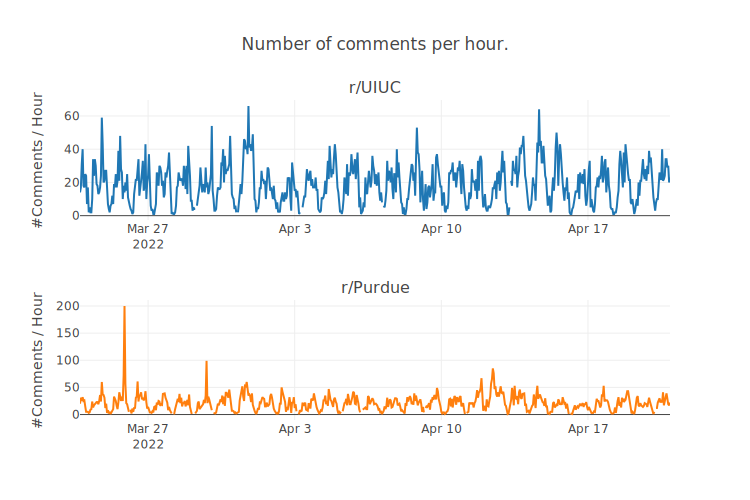

In [573]:
fig = display_subreddit_comment_series(['UIUC', 'Purdue'], requery=True)

fig.show('svg')
fig.write_image('figs/number_comments_per_hour.svg')

## Total number of comments.

In [574]:
def count_all_comments():
    return pd.DataFrame.from_dict({
        'Comments': all_comments.estimated_document_count()
    }, orient='index').rename(columns={0: 'N'})

count_all_comments()

,N
Comments,195200000


# Regression Analysis
<a id="regression"></a>

What's the question you're asking?



In [630]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

def format_formula(dependent, independent):
    return dependent + ' ~ ' + ' + '.join(independent)

## What influences the number of newcomers on an r/popular thread?

In [656]:
def newcomer_regression():

    independent = [
        'created_to_popular',
        'popular_window',
        'active_window',
        'num_moderators',
        'num_subscribers'
    ]

    formula = format_formula('percent_newcomers', independent)

    data = thread_master.join(
        subreddit_master[['num_moderators', 'num_subscribers']], on='subreddit')

    display(data[independent].agg(['mean', 'std']))
    
    for variable in independent:
        data[variable] = \
            (data[variable] - data[variable].mean()) / data[variable].std()

    model = smf.ols(formula=formula, data=data).fit(disp=False)
    
    display(model.summary())
    
    return model


model = newcomer_regression()

,created_to_popular,popular_window,active_window,num_moderators,num_subscribers
mean,18644.449472,21143.090498,725114.980392,27.142157,5.753938e+06
std,11532.632890,16590.773213,615346.821873,7.276021,8.432770e+06


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      percent_newcomers   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     16.67
Date:                Thu, 21 Apr 2022   Prob (F-statistic):           1.91e-15
Time:                        13:56:46   Log-Likelihood:                 327.41
No. Observations:                 612   AIC:                            -642.8
Df Residuals:                     606   BIC:                            -616.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2308      0.006     40.057      0.000       0.219       0.242
created_to_popular     0.0162      0.006      2.570      0.010       0.004       0.029
popular_window         0.0412      0.007      6.175      0.000       0.028       0.054
active_window          0.0090      0.006      1.445      0.149      -0.003       0.021
num_moderators         0.0135      0.006      2.291      0.022       0.002       0.025
num_subscribers       -0.0355      0.006     -6.113      0.000      -0.047      -0.024
==============================================================================
Omnibus:                      279.893   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1456.772
Skew:                           2.025   Prob(JB):                         0.00
Kurtosis:                       9.381   Cond. No.                         1.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [657]:
def removed_regression():
    
    independent = [
        'created_to_popular',
        'popular_window',
        'active_window',
        'num_moderators',
        'num_subscribers'
    ]
    
    formula = format_formula('percent_removed', independent)
    
    data = thread_master.join(
        subreddit_master[['num_moderators', 'num_subscribers']], on='subreddit')
    
    display(data[independent].agg(['mean', 'std']))
    
    for variable in independent:
        data[variable] = \
            (data[variable] - data[variable].mean()) / data[variable].std()
        
    model = smf.ols(formula=formula, data=data).fit(disp=False)
    
    display(model.summary())
    
    return model

model = removed_regression()

,created_to_popular,popular_window,active_window,num_moderators,num_subscribers
mean,18644.449472,21143.090498,725114.980392,27.142157,5.753938e+06
std,11532.632890,16590.773213,615346.821873,7.276021,8.432770e+06


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        percent_removed   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.629
Date:                Thu, 21 Apr 2022   Prob (F-statistic):             0.0230
Time:                        13:58:02   Log-Likelihood:                 1280.0
No. Observations:                 612   AIC:                            -2548.
Df Residuals:                     606   BIC:                            -2522.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0172      0.001     14.168      0.000       0.015       0.020
created_to_popular     0.0014      0.001      1.044      0.297      -0.001       0.004
popular_window        -0.0012      0.001     -0.846      0.398      -0.004       0.002
active_window         -0.0028      0.001     -2.168      0.031      -0.005      -0.000
num_moderators         0.0011      0.001      0.850      0.396      -0.001       0.003
num_subscribers        0.0021      0.001      1.728      0.084      -0.000       0.005
==============================================================================
Omnibus:                      559.835   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14214.831
Skew:                           4.159   Prob(JB):                         0.00
Kurtosis:                      25.096   Cond. No.                         1.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [645]:
def get_vif():

    independent = [
        'created_to_popular',
        'popular_window',
        'active_window',
        'num_authors',
        'num_comments',
        'num_moderators',
        'num_subscribers'
    ]

    data = thread_master.join(
        subreddit_master[['num_moderators', 'num_subscribers']], on='subreddit')
    
    data = data[independent]
    
    vif_data = pd.DataFrame(index=data.columns)
    
    vif_data['VIF'] = [vif(data.values, i) for i in range(len(data.columns))]
    
    display(vif_data)
    
get_vif()

,VIF
created_to_popular,3.091070
popular_window,3.312068
active_window,2.929242
num_authors,40.386021
num_comments,41.867001
num_moderators,4.644278
num_subscribers,1.490795


In [393]:
def plot_two_features(df, x, y):
    fig = px.scatter(
        x=df[x].values,
        y=df[y].values
    )
    
    fig.update_layout(
        template='none',
        showlegend=False,
        xaxis_title=x,
        yaxis_title=y,
        height=600,
        width=800
    )
    
    return fig

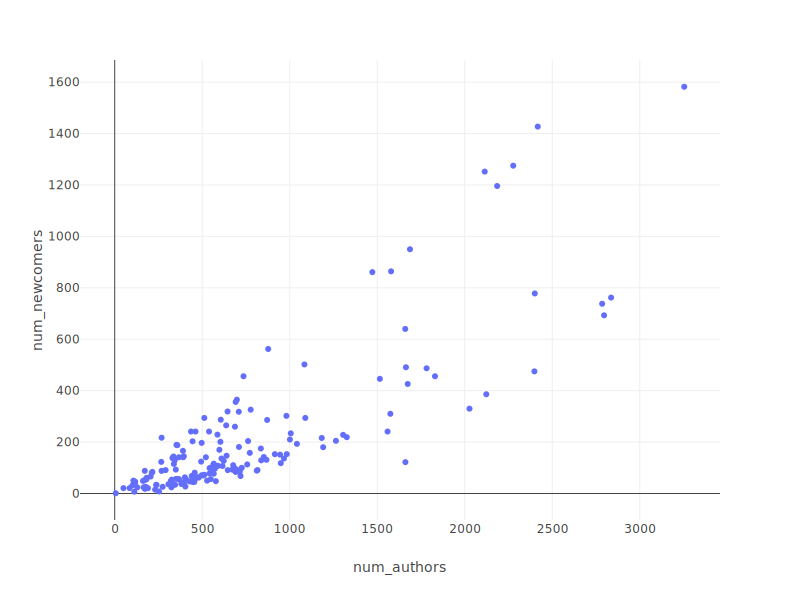

In [394]:
plot_two_features(thread_master, 'num_authors', 'num_newcomers').show('svg')

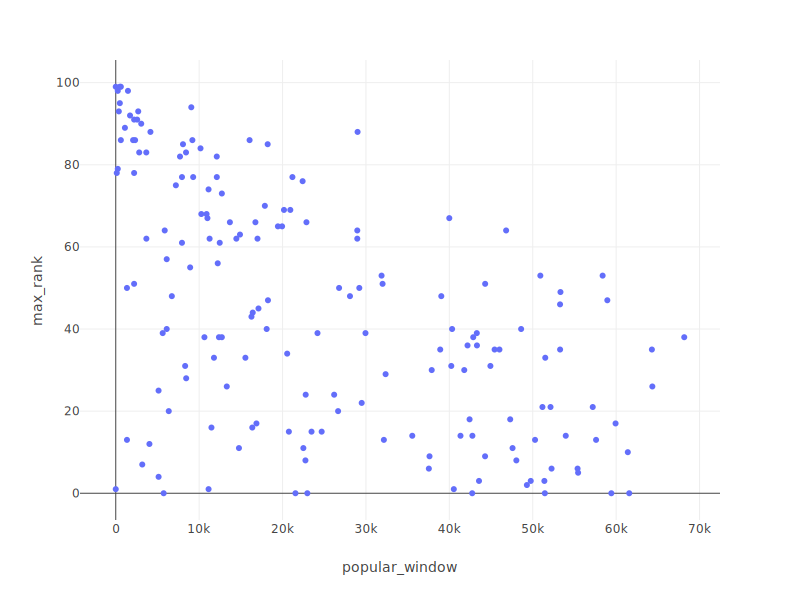

In [395]:
plot_two_features(thread_master, 'popular_window', 'max_rank').show('svg')

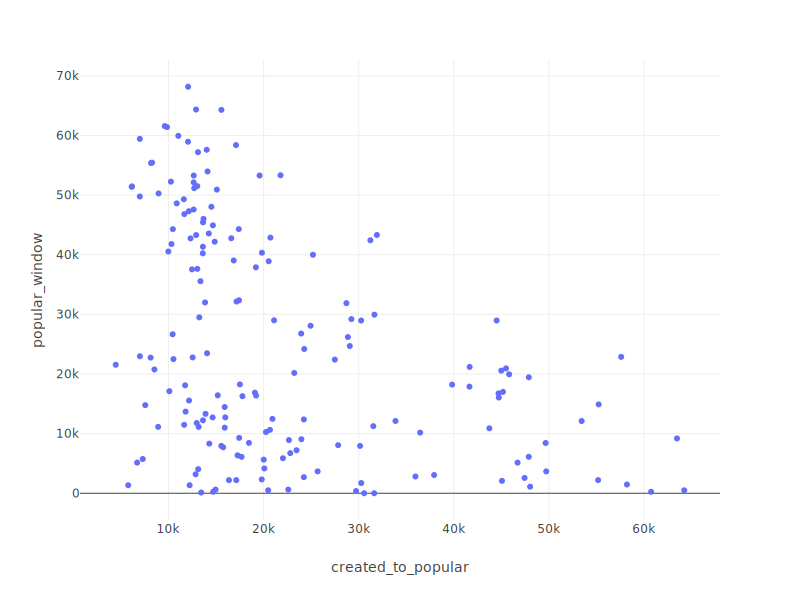

In [396]:
plot_two_features(thread_master, 'created_to_popular', 'popular_window').show('svg')

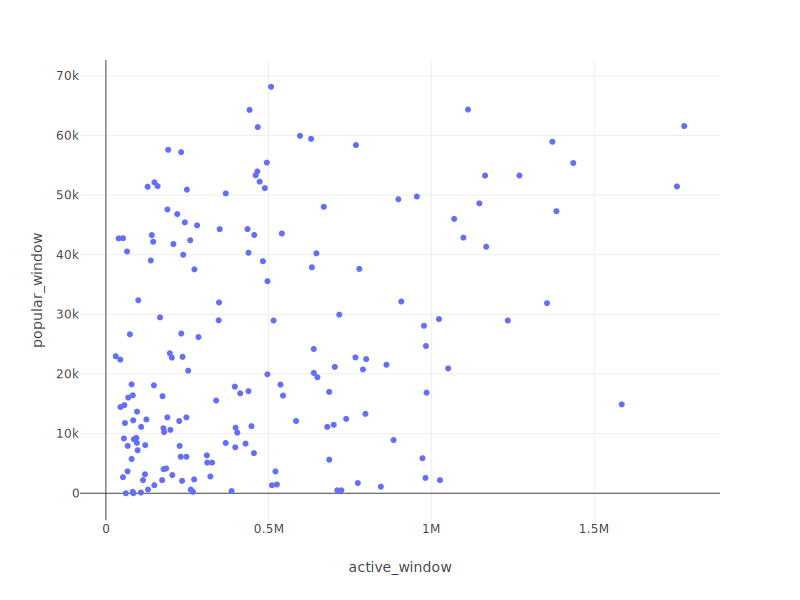

In [397]:
plot_two_features(thread_master, 'active_window', 'popular_window').show('svg')

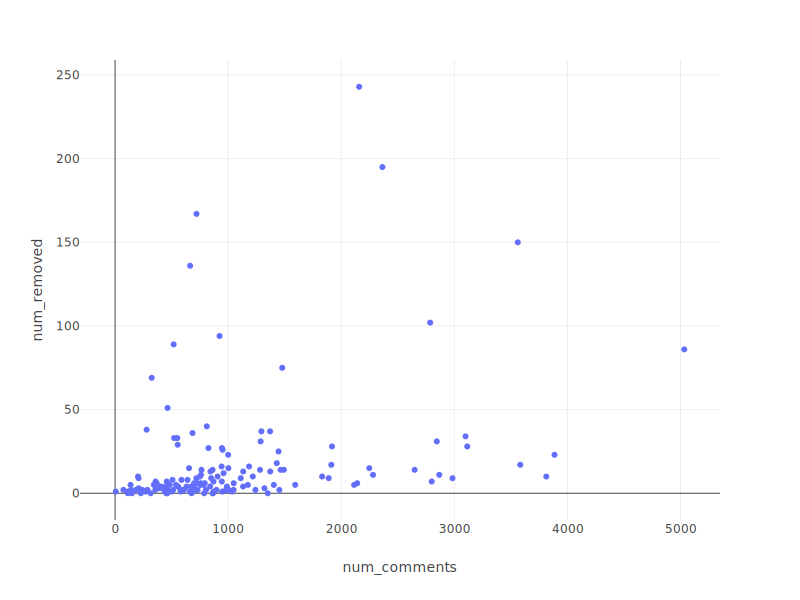

In [402]:
plot_two_features(thread_master, 'num_comments', 'num_removed').show('svg')

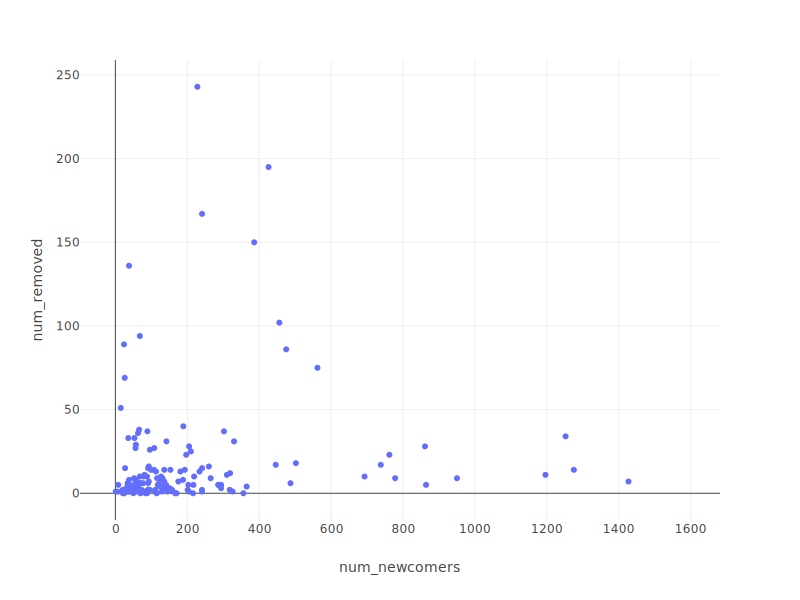

In [411]:
plot_two_features(thread_master, 'num_newcomers', 'num_removed').show('svg')